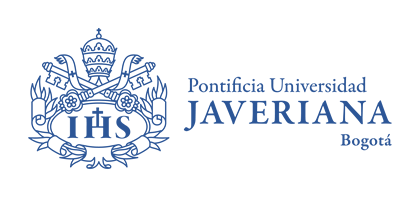

# Aprendizaje de Máquina - Proyecto: Clasificación géneros musicales

- Alejandro Morales Contreras
- Juan Sebastián Vargas Torres

## Contexto

Los expertos han estado tratando durante mucho tiempo de comprender el sonido y lo que diferencia una canción de otra. Cómo visualizar el sonido. Lo que hace que un tono sea diferente de otro.

Con suerte, estos datos pueden brindar la oportunidad de hacer precisamente eso.

## Contenido
Géneros originales: una colección de 10 géneros con 100 archivos de audio cada uno, todos con una duración de 30 segundos (el famoso conjunto de datos GTZAN, el MNIST de sonidos)


1 archivos CSV: contiene características de los archivos de audio. Tiene para cada canción (30 segundos de duración) una media y una varianza calculadas sobre múltiples funciones que se pueden extraer de un archivo de audio. 


## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import librosa
import requests


from sklearn.metrics import (
    confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc,accuracy_score
)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Funciones Útiles

In [ ]:
def  getLimitsAndMedian(attribute, n=1.5):

  # Cuartil 1
  q1 = attribute.quantile(0.25)
 
  # Cuartil 3
  q3 = attribute.quantile(0.75)

  med = attribute.median()
  
  # IQR
  iqr = q3-q1
  
  upper_bound = q3+(n*iqr)
  lower_bound = q1-(n*iqr)

  print("Q1: ",q1," Q3: ", q3," Median: ", med," IQR: ", iqr)
  return upper_bound, lower_bound, med

In [ ]:
def print_stats(y_test, y_pred):
  """
  Prints the accuracy, precision, recall and F1-score stats for the given labels

  Args:
  - y_test, true labels
  - y_pred, predicted labels
  """
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred, average="weighted"))
  print("Recall:", recall_score(y_test, y_pred,average="weighted"))
  print("F1-Score:", f1_score(y_test, y_pred,average="weighted"))

In [ ]:
def print_confusion_matrix(y_test, y_pred):
  """
  Draws a confusion matrix for the given labels

  Args:
  - y_test, true labels
  - y_pred, predicted labels
  """
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
  plt.title('Confusion Matrix')
  plt.xlabel('true label')
  plt.ylabel('predicted label')

In [ ]:
def print_train_val_graph(model):
  """
  Draws a confusion matrix for the given labels

  Args:
  - y_test, true labels
  - y_pred, predicted labels
  """
  plt.plot(model.loss_curve_)
  plt.plot( 1 - np.array(model.validation_scores_))
  plt.legend(['Train','Validation'])

## Lectura de datos

In [ ]:
music_df = pd.read_csv("https://github.com/Sebas102507/MusicGenreClassifier_AI/blob/main/data/features_30_sec.csv?raw=True")

## Exploración de datos

In [ ]:
music_df.shape

(1000, 60)

In [ ]:
music_df.head(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
music_df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [ ]:
music_df.isna().sum()

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

In [ ]:
music_df.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,0.103612,0.002986,-3.659332e-04,0.012540,-0.000395,5.670073e-03,119.505363,-144.472987,3747.875414,99.554278,706.899539,-8.920291,468.286436,36.292447,220.447219,-1.144840,174.404462,14.633491,127.232071,-5.129038,116.367019,10.119172,88.198988,-6.994062,88.566933,7.729785,81.733490,-6.021069,75.551228,4.471693,68.670817,-4.795884,67.871712,1.781900,64.764096,-3.869308,62.873761,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,0.041821,0.003024,1.683946e-03,0.011653,0.001082,6.500325e-03,28.264176,100.229406,2770.558394,31.330873,439.120256,21.690676,287.143462,16.664665,116.236941,12.221340,100.767823,11.839591,68.475115,9.940460,58.400048,10.463270,41.048213,8.283921,39.494072,7.937309,36.733649,6.817013,38.135183,6.715787,32.625534,6.170181,33.154276,5.008385,34.450290,4.873599,33.904101,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,0.021697,0.000044,-2.606458e-02,0.000049,-0.007150,8.299008e-07,54.978391,-552.120056,174.571365,-1.461542,93.104752,-89.870193,35.467754,-18.727547,34.263149,-38.890347,29.912008,-28.415911,20.847921,-32.930431,29.027332,-24.915823,22.464230,-31.640574,25.825863,-12.050177,19.273201,-28.057501,21.402756,-15.796446,18.642517,-27.523129,17.293922,-12.594489,14.250607,-17.539125,9.769691,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,0.070244,0.001079,-1.041584e-04,0.004383,-0.000537,1.292592e-03,99.384014,-200.763893,1844.488129,76.779915,398.020767,-24.219811,270.466576,24.108212,129.397377,-9.979157,101.266209,5.098573,76.505194,-12.870810,73.546917,1.609181,57.349041,-13.246939,59.882313,1.620753,55.734016,-10.964135,51.242420,-0.547371,46.854038,-9.357906,46.294396,-1.639417,43.416593,-7.165884,42.236251,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,0.099503,0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50ee5aa650>,
      dtype=object)

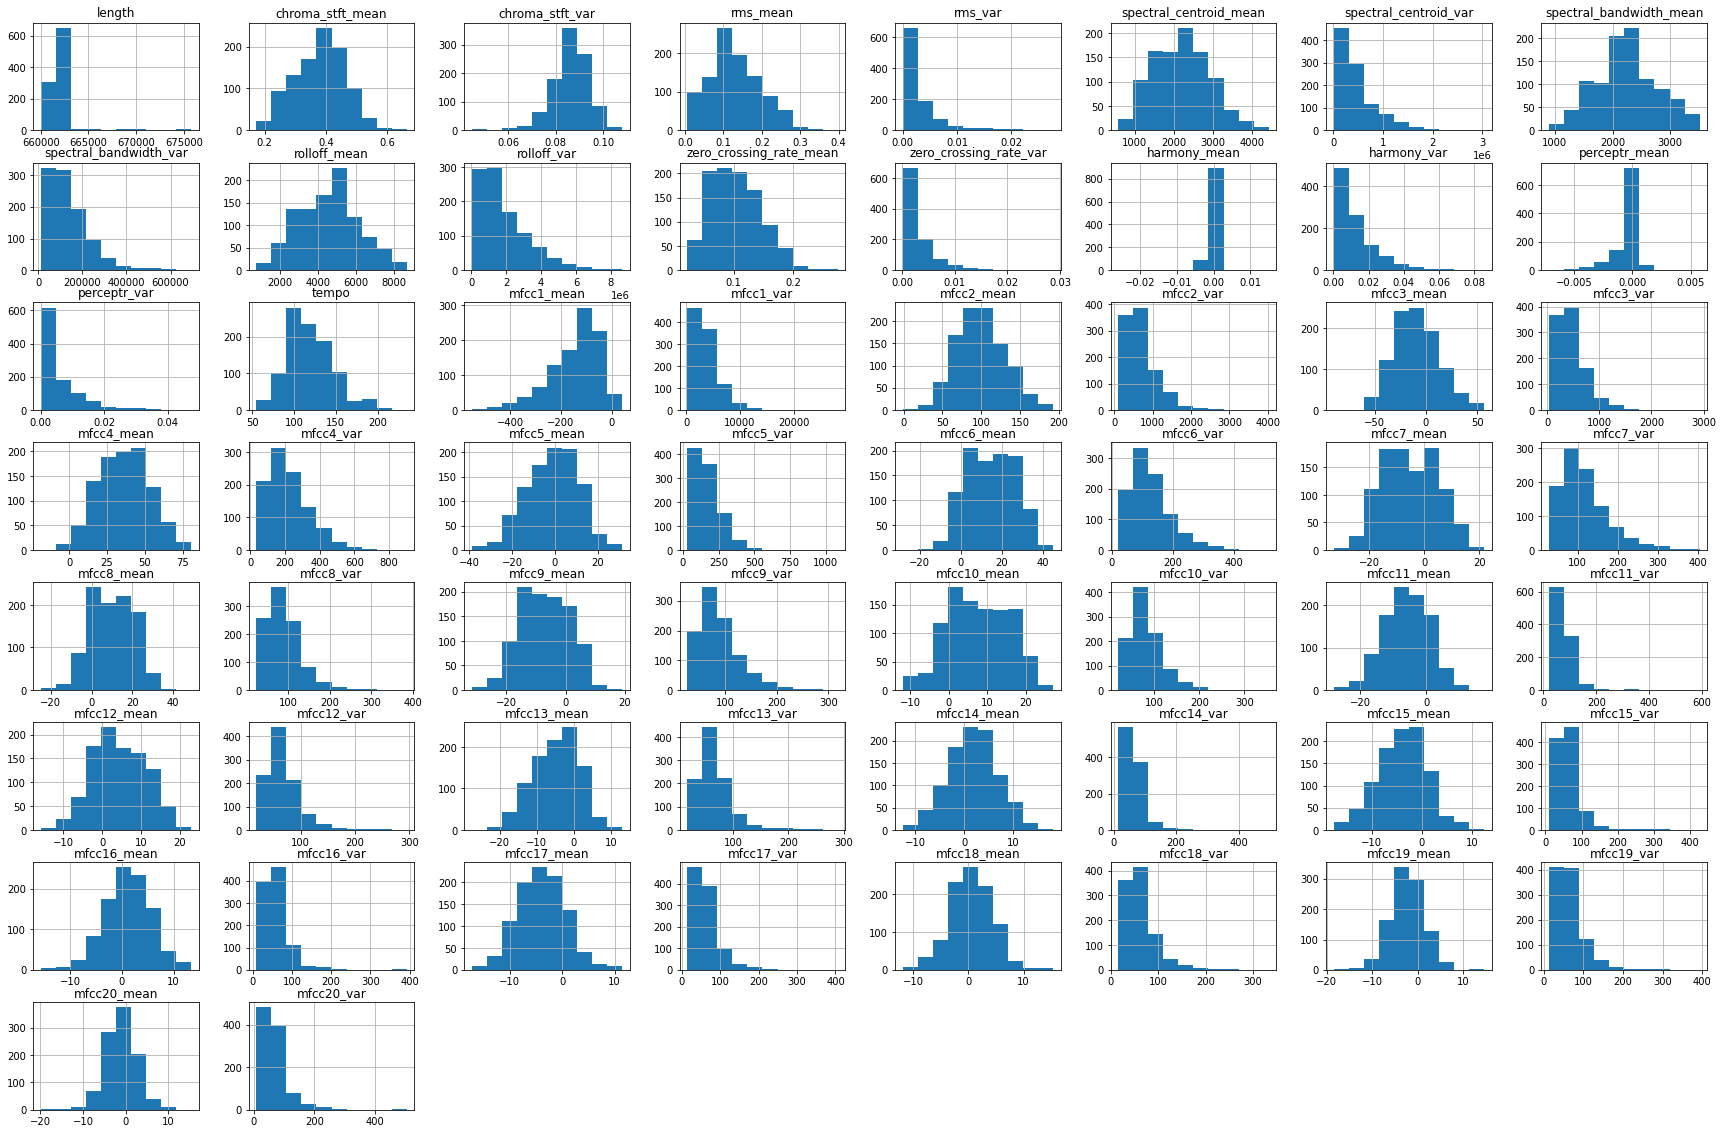

In [ ]:
music_df.hist(figsize=(30, 20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

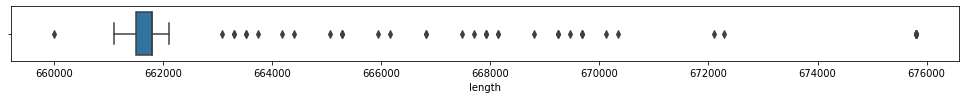

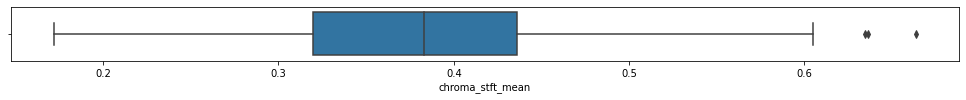

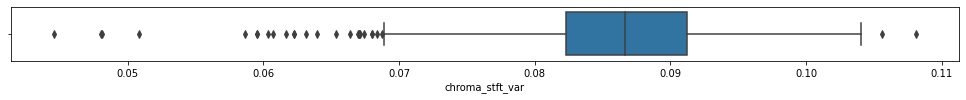

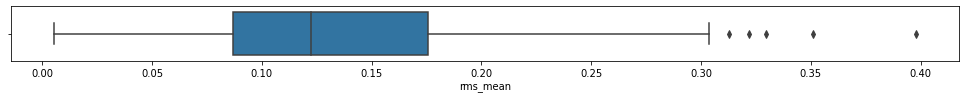

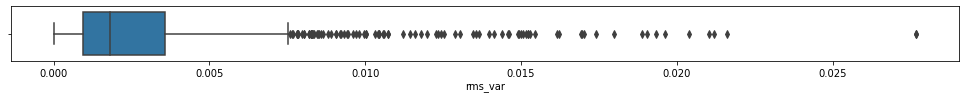

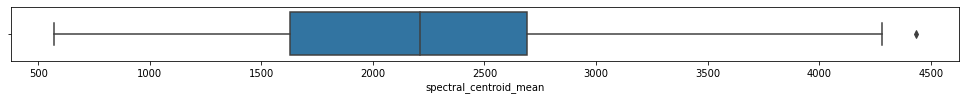

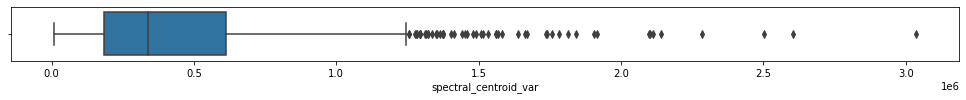

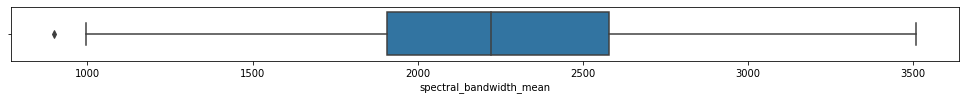

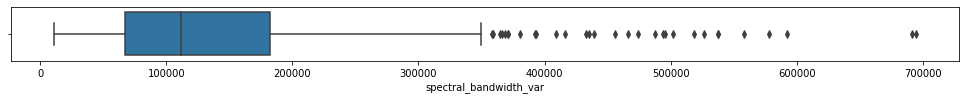

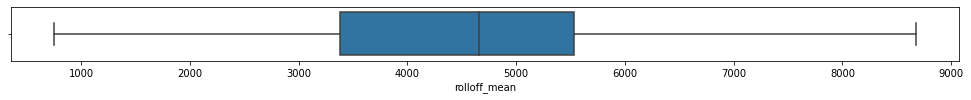

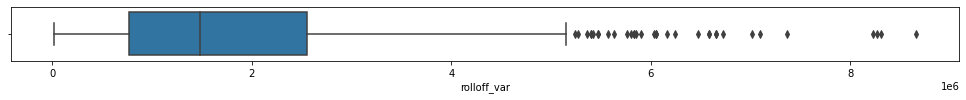

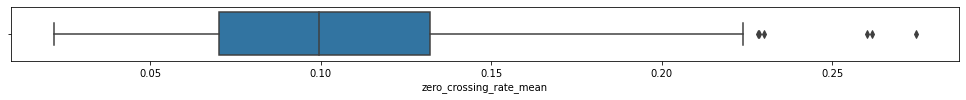

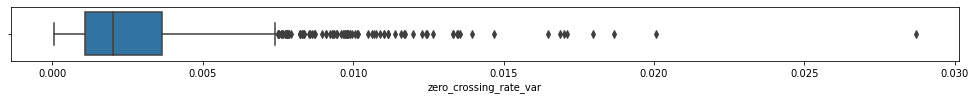

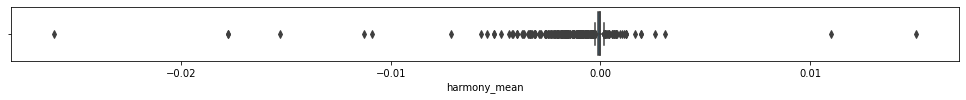

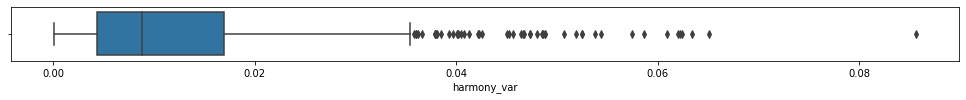

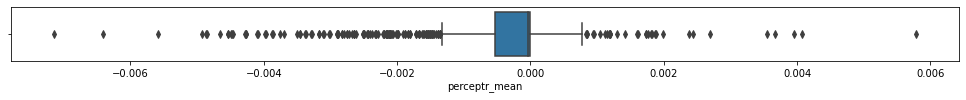

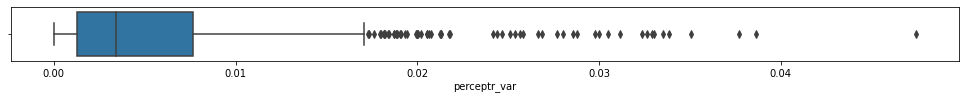

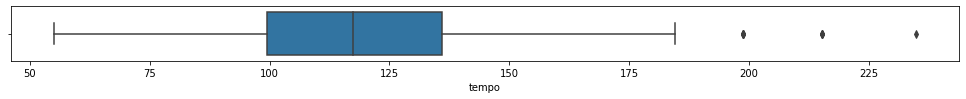

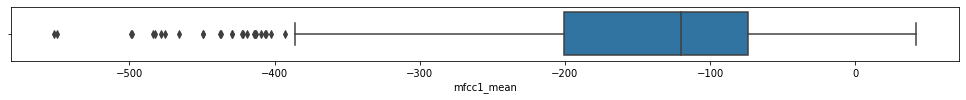

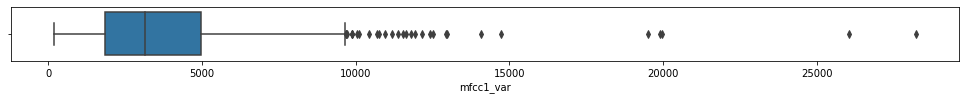

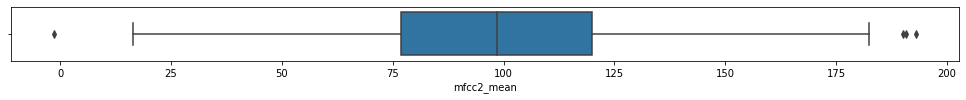

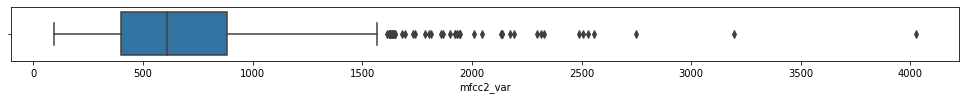

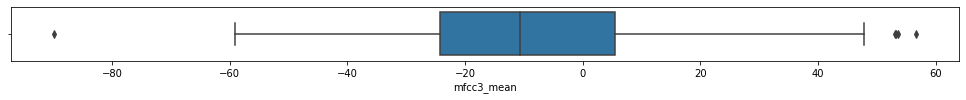

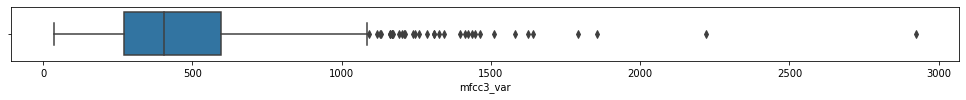

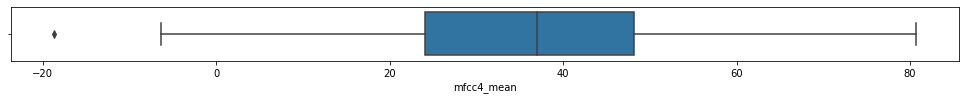

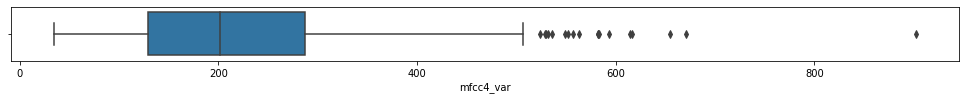

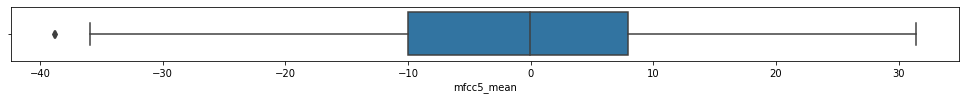

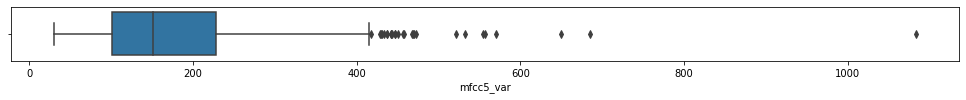

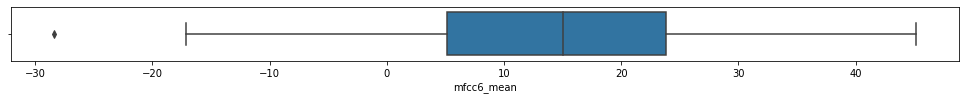

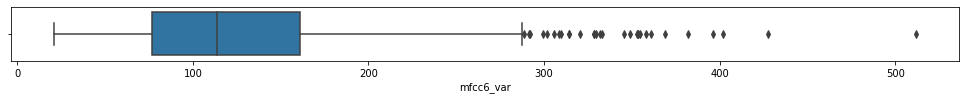

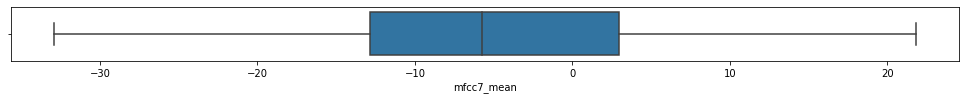

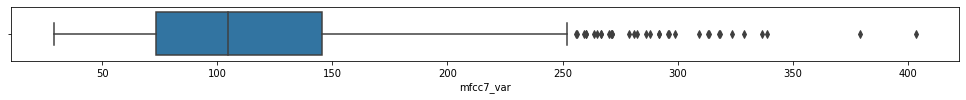

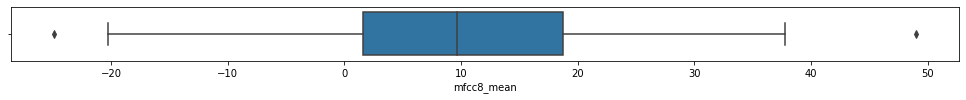

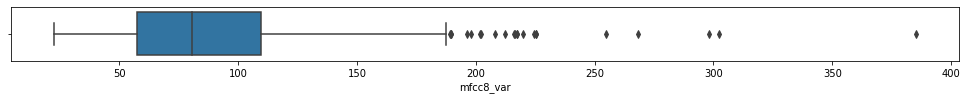

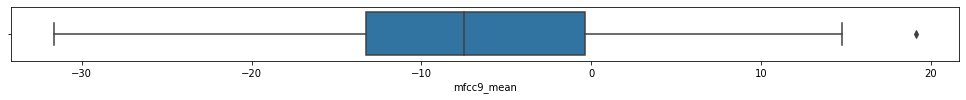

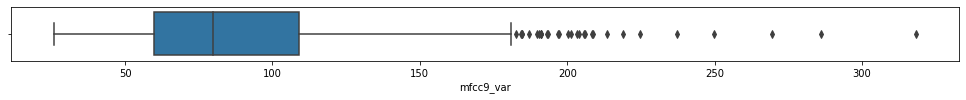

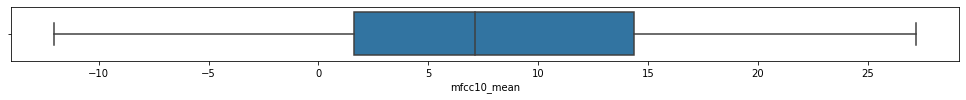

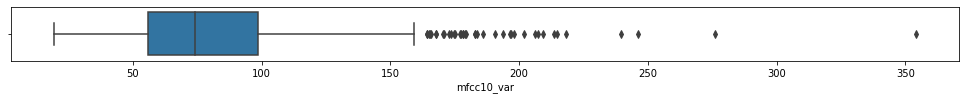

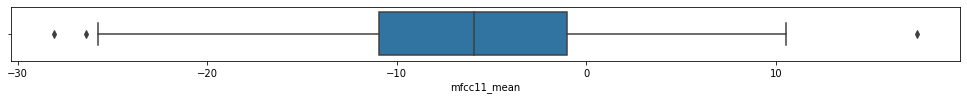

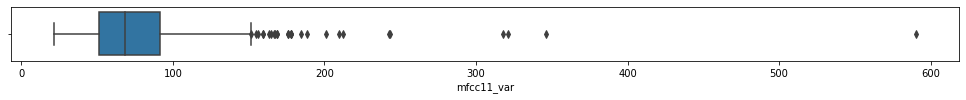

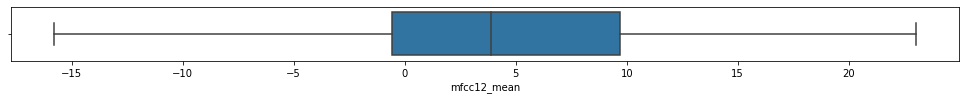

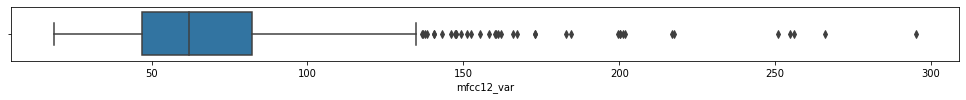

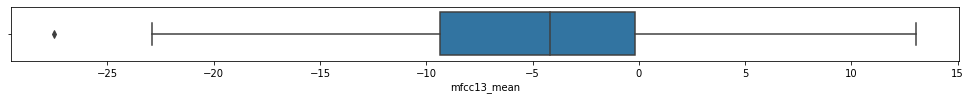

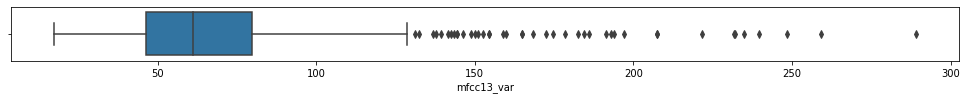

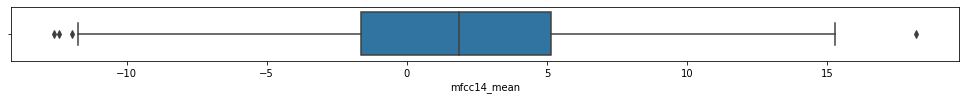

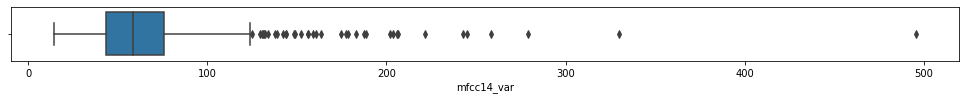

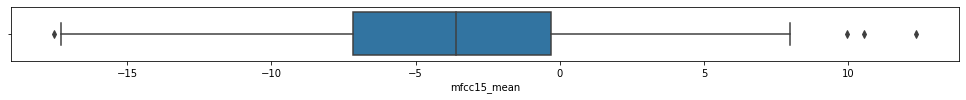

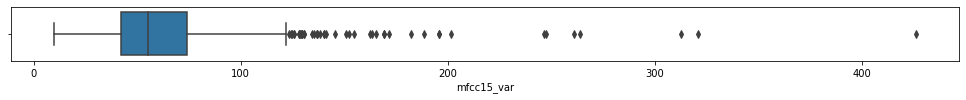

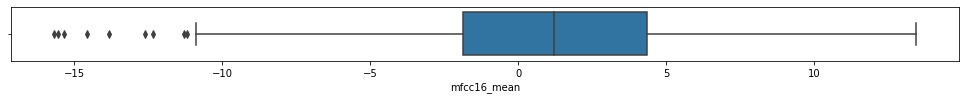

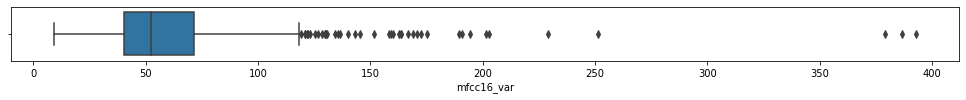

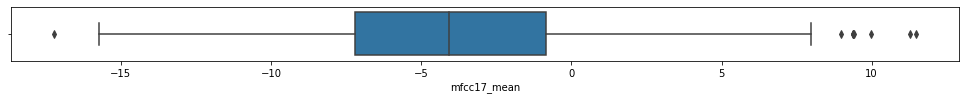

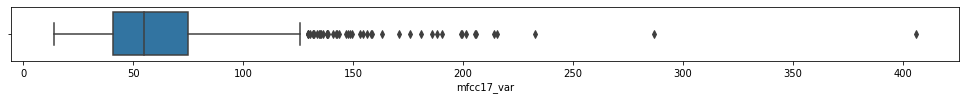

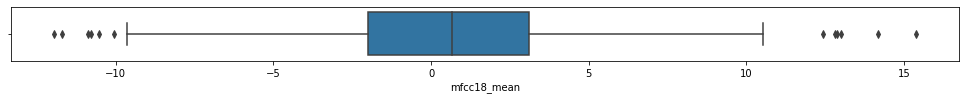

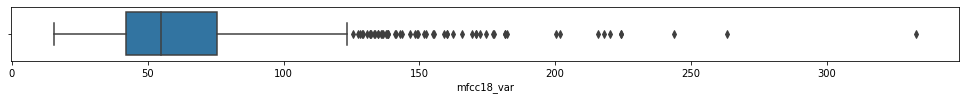

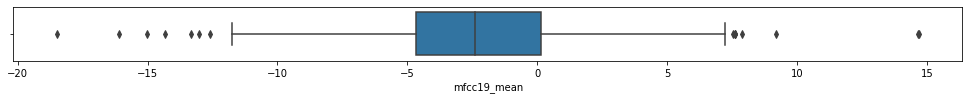

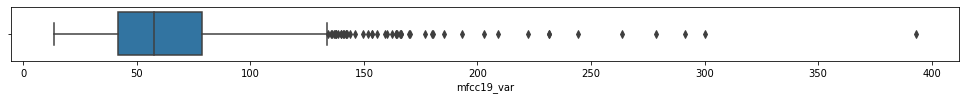

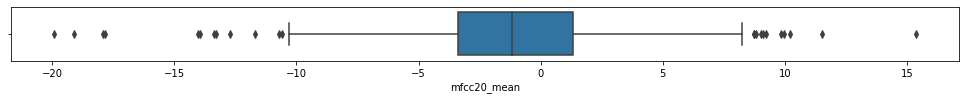

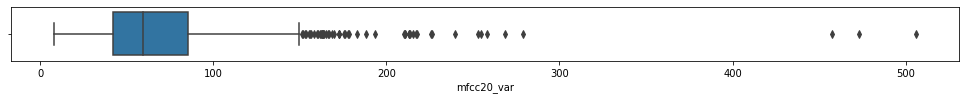

In [ ]:
df_numeric=music_df.select_dtypes(exclude=['object'])
for column in df_numeric:
    plt.figure(figsize=(17,1))
    sns.boxplot(data=df_numeric, x=column)

In [ ]:
corr = music_df[music_df.columns[:-1]].corr()
corr.style.background_gradient(cmap='coolwarm')

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
length,1.000000,0.017426,0.073979,0.101801,0.116661,0.052175,0.121994,0.062503,0.118993,0.040363,0.106346,0.025562,0.113593,0.022029,0.109892,-0.046251,0.077283,0.060316,0.054666,0.127369,-0.086796,0.136095,0.058542,0.085642,-0.114049,0.081549,0.105022,0.062592,-0.121300,0.089809,0.114826,0.060114,-0.083152,0.096725,0.114684,0.054959,-0.052095,0.057638,0.168307,0.051005,-0.043836,0.084516,0.142020,0.038884,-0.059199,0.005673,0.110454,0.023164,-0.019677,0.025483,0.039179,0.003457,-0.025331,0.014822,0.010576,0.045884,0.014803,0.050338
chroma_stft_mean,0.017426,1.000000,-0.461729,0.499926,0.261544,0.615728,0.285926,0.517710,0.041088,0.598122,0.117139,0.554771,0.355920,0.031963,0.281150,-0.116567,0.465995,0.018477,0.659550,-0.125173,-0.598713,-0.052177,-0.054353,0.003765,0.264147,0.132253,-0.010085,0.038402,0.416877,0.101364,0.067508,0.066712,0.509776,-0.026696,0.116040,-0.151147,0.489229,-0.192695,0.072779,-0.301768,0.516690,-0.408530,-0.081445,-0.438212,0.417091,-0.444702,-0.143372,-0.440796,0.332359,-0.452955,-0.163474,-0.456298,0.269935,-0.478452,-0.089509,-0.501768,0.281965,-0.548577
chroma_stft_var,0.073979,-0.461729,1.000000,-0.078777,0.290138,-0.246441,0.305819,-0.036896,0.346907,-0.168721,0.383134,-0.470186,0.169289,-0.006378,0.047447,0.086584,0.020981,-0.079209,-0.343372,0.367570,0.118888,0.353811,0.412857,0.421817,-0.252334,0.394627,0.354068,0.414076,-0.209684,0.447260,0.277560,0.433032,-0.318189,0.450482,0.206969,0.469733,-0.292359,0.421070,0.231738,0.395838,-0.359185,0.382765,0.314236,0.383944,-0.275502,0.365766,0.273446,0.372656,-0.311178,0.361752,0.205117,0.389468,-0.239597,0.378200,0.184323,0.365291,-0.231715,0.333581
rms_mean,0.101801,0.499926,-0.078777,1.000000,0.607399,0.510154,0.324077,0.530017,0.099830,0.537902,0.200083,0.332163,0.319304,0.064440,0.893898,-0.009166,0.789994,-0.052634,0.807239,-0.179467,-0.484057,-0.009069,0.139513,-0.024116,0.008731,0.180446,0.108939,0.068321,0.125682,0.213669,0.167750,0.114015,0.178947,0.083730,0.216109,0.011487,0.186127,-0.005768,0.117318,-0.118258,0.183280,-0.195578,0.013036,-0.236572,0.163009,-0.216350,-0.011154,-0.214653,0.083936,-0.160347,-0.029562,-0.163490,0.118239,-0.164834,0.031297,-0.207680,0.124413,-0.252434
rms_var,0.116661,0.261544,0.290138,0.607399,1.000000,0.347831,0.583353,0.402333,0.320793,0.368570,0.417880,0.156530,0.568643,0.084849,0.585318,0.123557,0.789910,-0.118671,0.326590,0.276735,-0.368384,0.348277,0.297067,0.351018,-0.234197,0.465319,0.265403,0.359638,-0.155544,0.533171,0.312285,0.357660,-0.126337,0.407201,0.328440,0.329269,-0.071458,0.287186,0.266139,0.180124,-0.077560,0.106692,0.229806,0.099020,-0.037588,0.059604,0.211396,0.062595,-0.093893,0.091863,0.168169,0.100234,-0.002585,0.058050,0.186953,0.049879,0.029364,0.012087
spectral_centroid_mean,0.052175,0.615728,-0.246441,0.510154,0.347831,1.000000,0.520548,0.904435,0.011256,0.979637,0.198031,0.874749,0.671771,0.053695,0.316211,-0.013444,0.559647,-0.025764,0.721006,-0.201153,-0.940180,-0.017894,0.188000,-0.099545,-0.136810,0.153690,0.069132,-0.078022,0.017597,0.171060,0.215637,0.024782,0.134407,0.051892,0.288884,-0.066127,0.192896,-0.069192,0.152689,-0.143950,0.175123,-0.234021,0.051308,-0.220678,0.170910,-0.203427,0.022383,-0.204568,0.153741,-0.180200,0.027473,-0.158666,0.228275,-0.136272,0

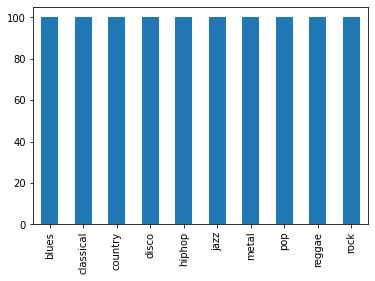

In [ ]:
music_df["label"].value_counts().plot(kind='bar')

## Limpieza de datos

### Eliminación de columnas innecesarias

In [ ]:
music_df.drop(columns=["filename"],inplace=True)

### Eliminación de columnas altamente correlacionadas

In [ ]:
cor_matrix = music_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(); print(to_drop)


['spectral_bandwidth_mean', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'harmony_var', 'mfcc2_mean', 'mfcc20_var']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
music_df.drop(music_df[to_drop], axis=1,inplace=True)

In [ ]:
music_df.shape

(1000, 52)

### Remplazo de valores atípicos

In [ ]:
for c in music_df.columns[:-1]:
  upper_bound, lower_bound,median = getLimitsAndMedian(music_df[c])
  music_df.loc[(music_df[c] > upper_bound) | (music_df[c] < lower_bound),c]=median

Q1:  661504.0  Q3:  661794.0  Median:  661794.0  IQR:  290.0
Q1:  0.3195615485310554  Q3:  0.4359417408704757  Median:  0.3831479102373123  IQR:  0.11638019233942032
Q1:  0.08229774422943585  Q3:  0.09125551395118235  Median:  0.08661462739109985  IQR:  0.0089577697217465
Q1:  0.08665709383785718  Q3:  0.1756821982562541  Median:  0.12244314327836035  IQR:  0.08902510441839694
Q1:  0.0009416309621883  Q3:  0.0035770548856817  Median:  0.0018164395005442  IQR:  0.0026354239234934
Q1:  1627.697311379151  Q3:  2691.294666698046  Median:  2209.2630899514425  IQR:  1063.597355318895
Q1:  184350.53017444146  Q3:  612147.9347808211  Median:  338486.15267359314  IQR:  427797.4046063796
Q1:  67376.55442757165  Q3:  182371.57680111512  Median:  111977.5480356058  IQR:  114995.02237354347
Q1:  0.0010791865090833  Q3:  0.003627869201666375  Median:  0.0020219505335093  IQR:  0.002548682692583075
Q1:  -0.0001041583800542  Q3:  6.643429912855936e-07  Median:  -3.1767832524565165e-06  IQR:  0.0001048

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

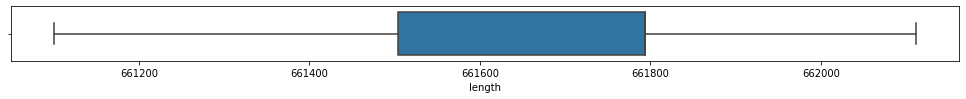

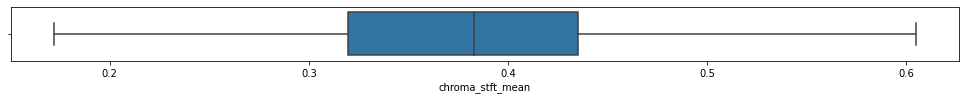

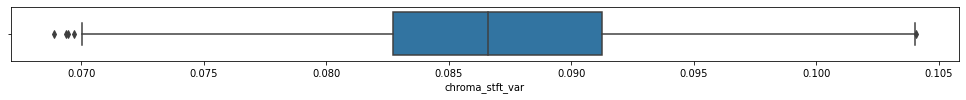

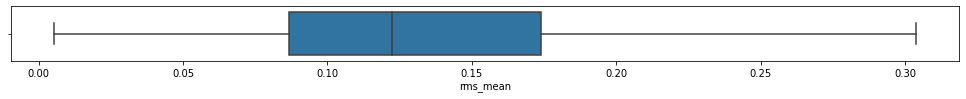

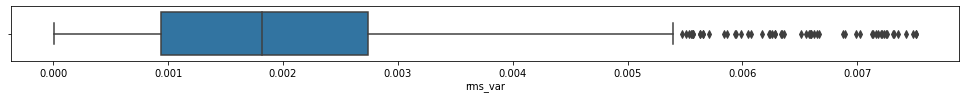

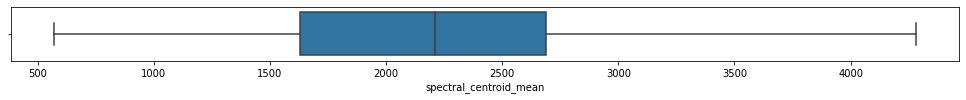

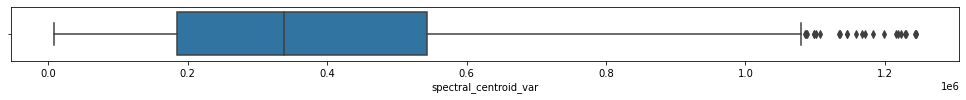

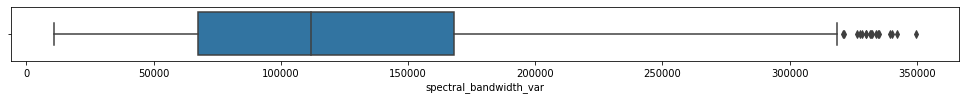

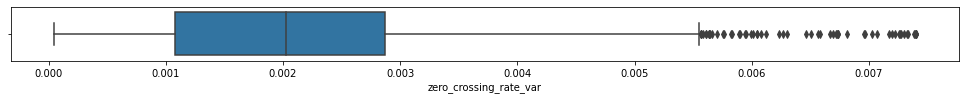

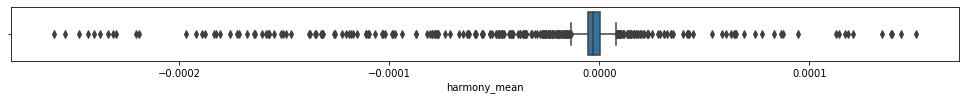

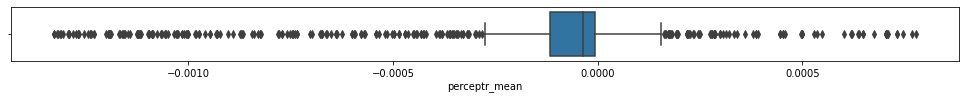

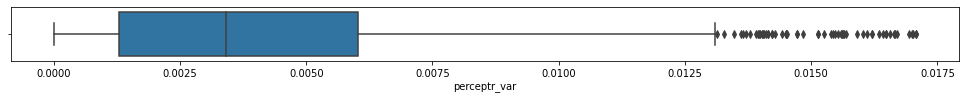

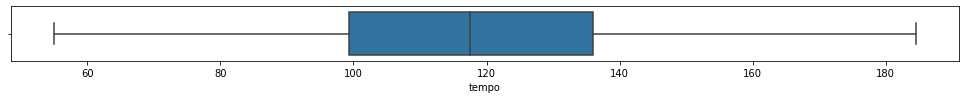

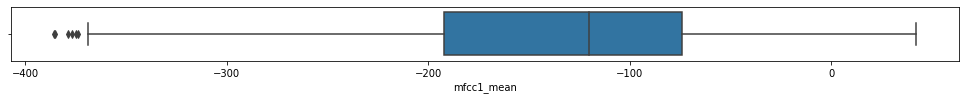

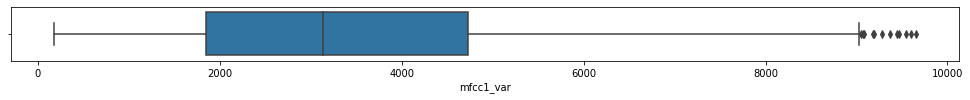

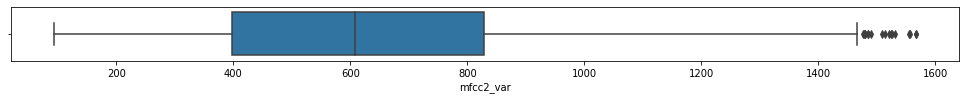

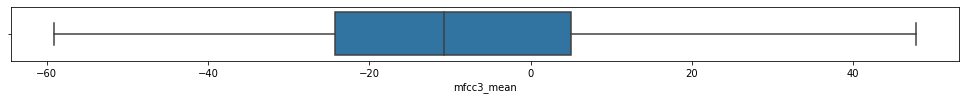

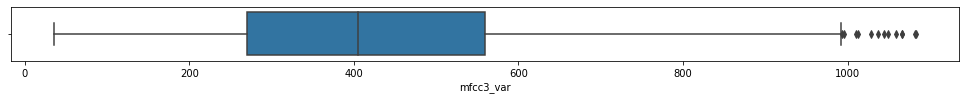

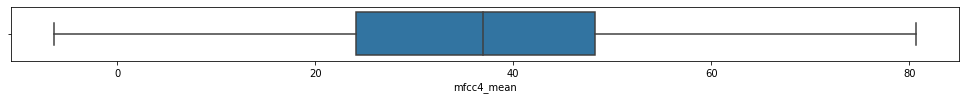

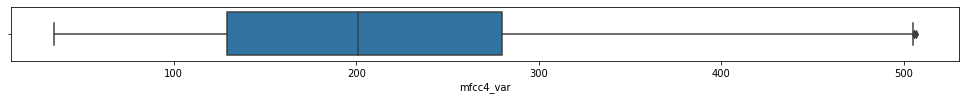

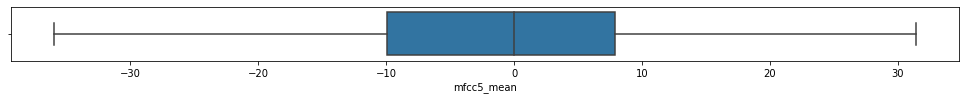

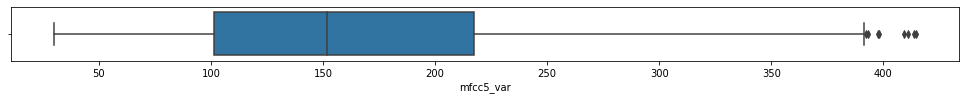

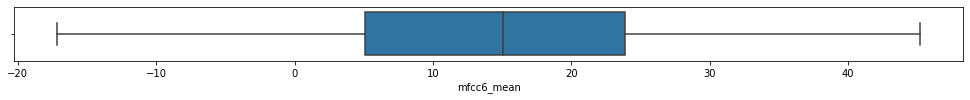

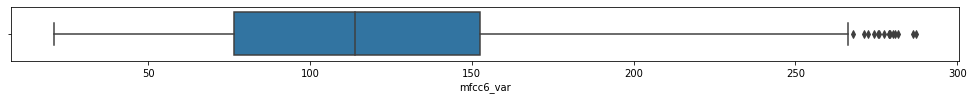

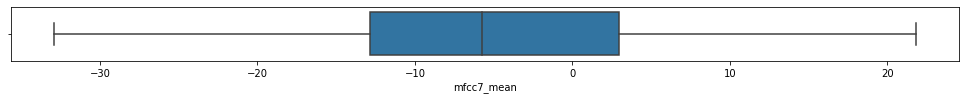

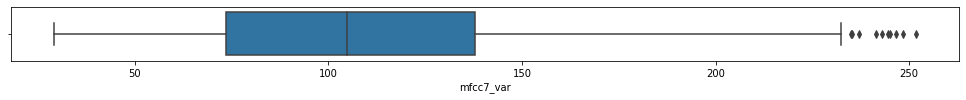

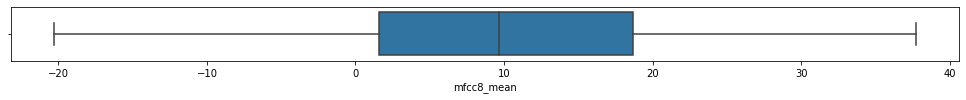

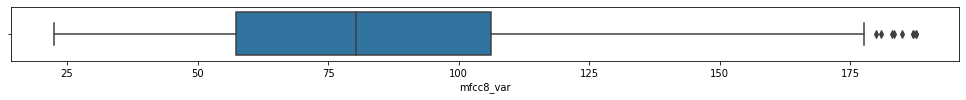

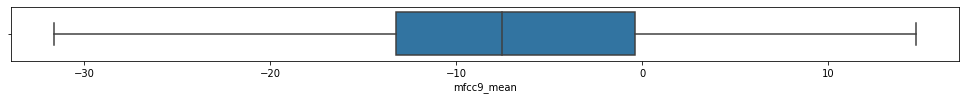

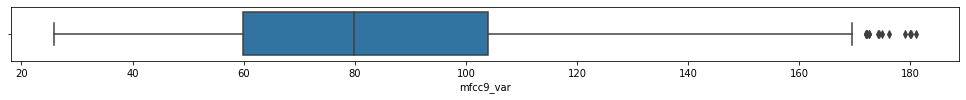

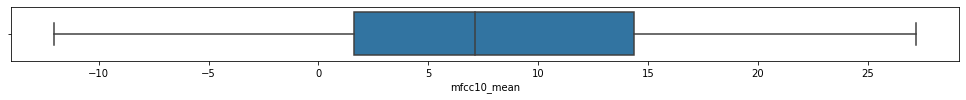

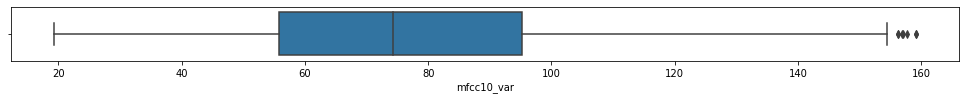

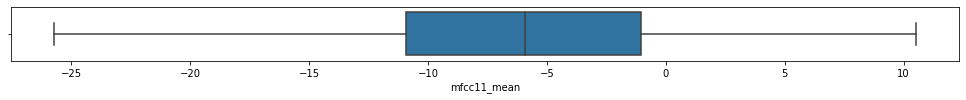

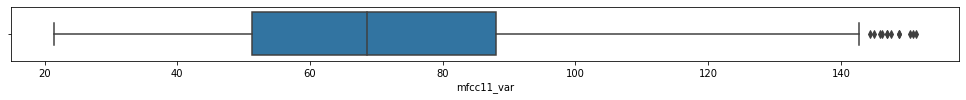

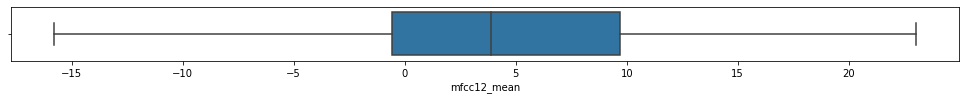

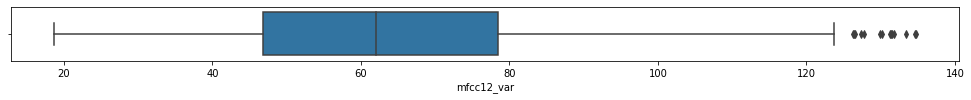

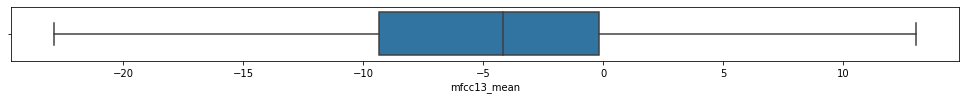

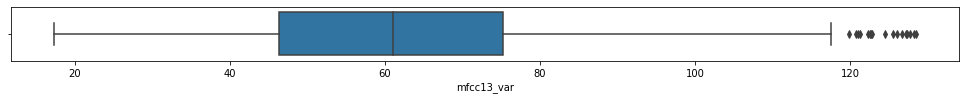

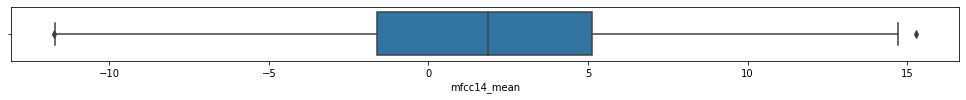

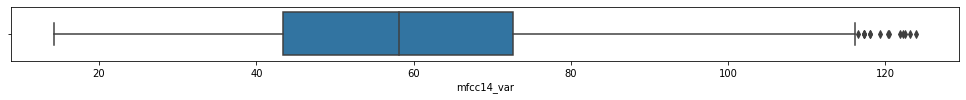

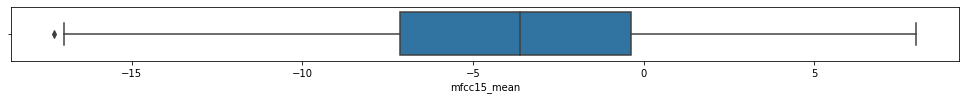

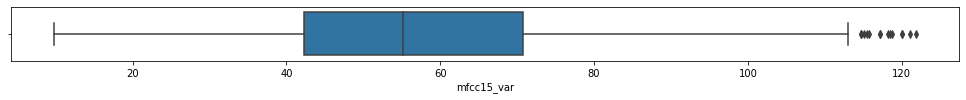

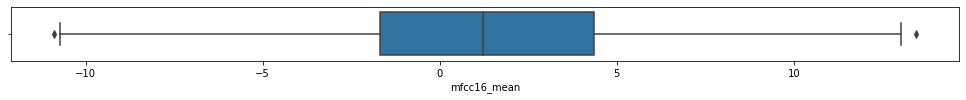

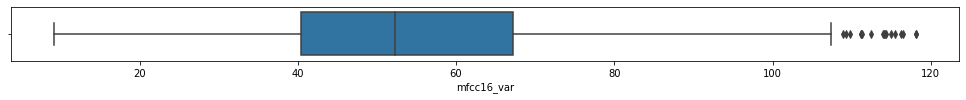

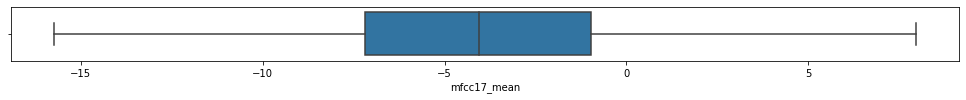

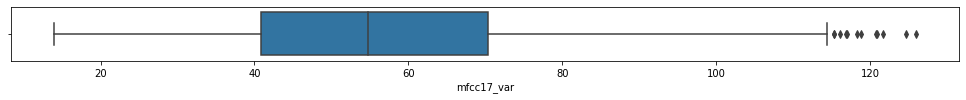

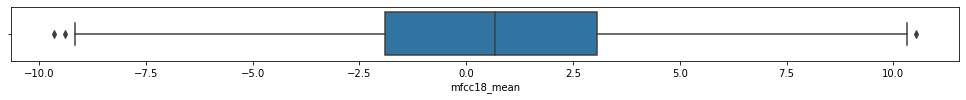

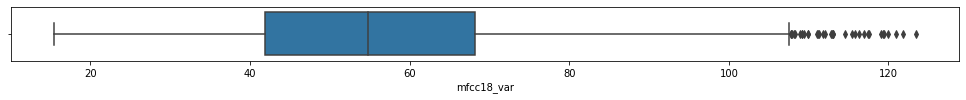

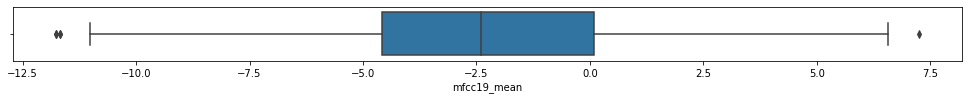

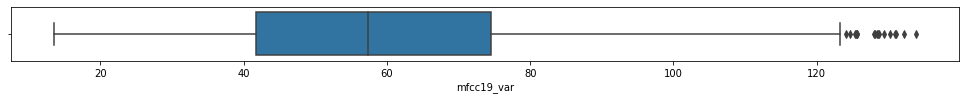

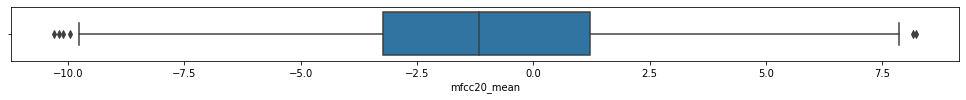

In [ ]:
df_numeric=music_df.select_dtypes(exclude=['object'])
for column in df_numeric:
    plt.figure(figsize=(17,1))
    sns.boxplot(data=df_numeric, x=column)

### Numerizar etiqueta

In [ ]:
music_df.head(5)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_var,zero_crossing_rate_var,harmony_mean,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,85882.761315,0.000767,-4.529724e-05,0.000008,0.005698,123.046875,-113.570648,2564.207520,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,213843.755497,0.001448,1.395807e-04,-0.000178,0.003063,67.999589,-207.501694,7764.555176,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,76254.192257,0.001007,2.105576e-06,-0.000019,0.007458,161.499023,-90.722595,3319.044922,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,166441.494769,0.000423,4.583644e-07,-0.000014,0.002712,63.024009,-199.544205,5507.517090,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,88445.209036,0.001954,-1.756129e-05,-0.000010,0.003094,135.999178,-160.337708,5195.291992,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-1.166289,blues


In [ ]:
music_df["label"].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [ ]:
labels_to_numeric ={"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

In [ ]:
music_df["label"]=music_df["label"].replace(labels_to_numeric)

In [ ]:
music_df.head(5)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_var,zero_crossing_rate_var,harmony_mean,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,85882.761315,0.000767,-4.529724e-05,0.000008,0.005698,123.046875,-113.570648,2564.207520,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,0
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,213843.755497,0.001448,1.395807e-04,-0.000178,0.003063,67.999589,-207.501694,7764.555176,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,0
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,76254.192257,0.001007,2.105576e-06,-0.000019,0.007458,161.499023,-90.722595,3319.044922,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,0
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,166441.494769,0.000423,4.583644e-07,-0.000014,0.002712,63.024009,-199.544205,5507.517090,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,0
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,88445.209036,0.001954,-1.756129e-05,-0.000010,0.003094,135.999178,-160.337708,5195.291992,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-1.166289,0


## Experimentos

### Init

In [ ]:
standarizer = StandardScaler()
networkModel = MLPClassifier()
logistcModel = LogisticRegression()
radomForestModel= RandomForestClassifier()

#### Split

In [ ]:
X = music_df[music_df.columns[:-1]]
Y =music_df["label"]

In [ ]:
X.head(5)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_var,zero_crossing_rate_var,harmony_mean,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,85882.761315,0.000767,-4.529724e-05,0.000008,0.005698,123.046875,-113.570648,2564.207520,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,213843.755497,0.001448,1.395807e-04,-0.000178,0.003063,67.999589,-207.501694,7764.555176,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,76254.192257,0.001007,2.105576e-06,-0.000019,0.007458,161.499023,-90.722595,3319.044922,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,166441.494769,0.000423,4.583644e-07,-0.000014,0.002712,63.024009,-199.544205,5507.517090,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,88445.209036,0.001954,-1.756129e-05,-0.000010,0.003094,135.999178,-160.337708,5195.291992,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-1.166289


In [ ]:
Y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=42)

### Redes Neuronales

In [ ]:
pipe1 = pipeline.Pipeline([('standarizer', standarizer), ('network', networkModel)])
pipe2 = pipeline.Pipeline([('standarizer', standarizer), ('network', networkModel)])
pipe3 = pipeline.Pipeline([('standarizer', standarizer), ('network', networkModel)])
pipe4 = pipeline.Pipeline([('standarizer', standarizer), ('network', networkModel)])
pipe5 = pipeline.Pipeline([('standarizer', standarizer), ('network', networkModel)])

#### Experimento 1

In [ ]:
params_exp_1={
        "network__hidden_layer_sizes": (32,32),
        "network__solver": "sgd",
        "network__batch_size":32,
        "network__early_stopping":True,
        "network__validation_fraction":0.2,
        "network__n_iter_no_change":10,
        "network__learning_rate_init": 0.001,
        "network__max_iter":100000
}

In [ ]:
pipe1.set_params(**params_exp_1)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(32, 32), max_iter=100000,
                               solver='sgd', validation_fraction=0.2))])

##### Entrenamiento

In [ ]:
pipe1.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(32, 32), max_iter=100000,
                               solver='sgd', validation_fraction=0.2))])

In [ ]:
net = pipe1.named_steps['network']

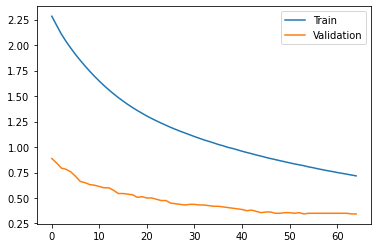

In [ ]:
print_train_val_graph(net)

##### Validación

In [ ]:
Y_predict_1 = pipe1.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_1)

Accuracy: 0.56
Precision: 0.5667691403349558
Recall: 0.56
F1-Score: 0.5532897217343679


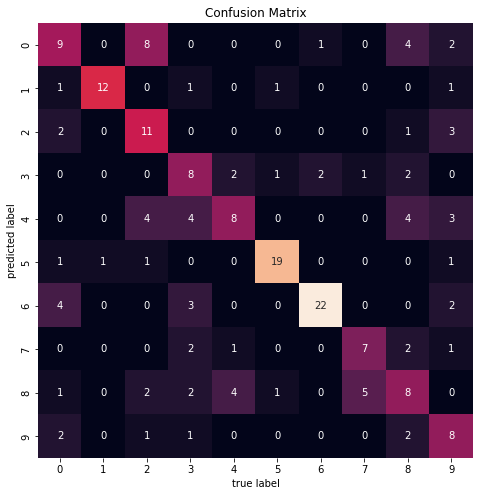

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_1)

#### Experimento 2

In [ ]:
params_exp_2={
        "network__hidden_layer_sizes": (32,32),
        "network__batch_size":32,
        "network__solver": "adam",
        "network__early_stopping":True,
        "network__validation_fraction":0.2,
        "network__n_iter_no_change":10,
        "network__learning_rate_init": 0.001,
        "network__max_iter":100000
}

In [ ]:
pipe2.set_params(**params_exp_2)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(32, 32), max_iter=100000,
                               validation_fraction=0.2))])

##### Entrenamiento

In [ ]:
pipe2.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(32, 32), max_iter=100000,
                               validation_fraction=0.2))])

In [ ]:
net = pipe2.named_steps['network']

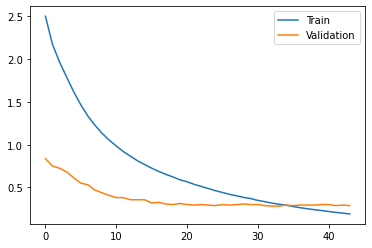

In [ ]:
print_train_val_graph(net)

##### Validación

In [ ]:
Y_predict_2 = pipe2.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_2)

Accuracy: 0.65
Precision: 0.6553973438841859
Recall: 0.65
F1-Score: 0.6490920882691653


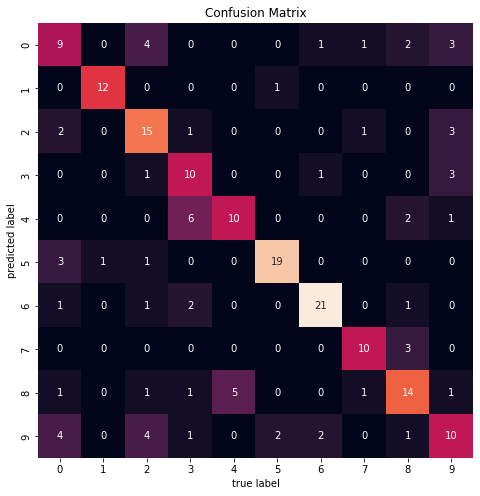

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_2)

#### Experimento 3

In [ ]:
params_exp_3={
        "network__hidden_layer_sizes": (64,64),
        "network__batch_size":32,
        "network__solver": "adam",
        "network__early_stopping":True,
        "network__validation_fraction":0.2,
        "network__n_iter_no_change":10,
        "network__learning_rate_init": 0.001,
        "network__max_iter":100000
}

In [ ]:
pipe3.set_params(**params_exp_3)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(64, 64), max_iter=100000,
                               validation_fraction=0.2))])

##### Entrenamiento

In [ ]:
pipe3.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(64, 64), max_iter=100000,
                               validation_fraction=0.2))])

In [ ]:
net = pipe3.named_steps['network']

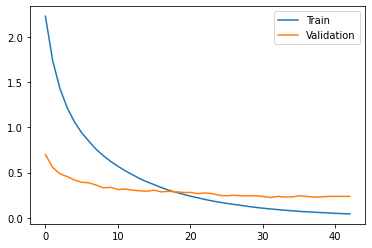

In [ ]:
print_train_val_graph(net)

##### Validación

In [ ]:
Y_predict_3 = pipe3.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_3)

Accuracy: 0.645
Precision: 0.6477442421413009
Recall: 0.645
F1-Score: 0.6434959981195613


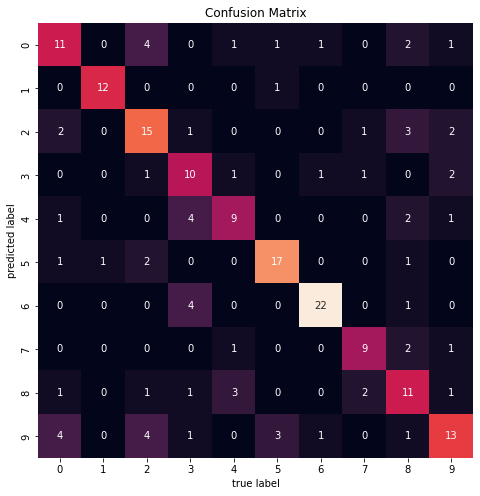

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_3)

#### Experimento 4

In [ ]:
params_exp_4={
        "network__hidden_layer_sizes": (64,64),
        "network__batch_size":32,
        "network__solver": "adam",
        "network__early_stopping":True,
        "network__validation_fraction":0.2,
        "network__n_iter_no_change":10,
        "network__learning_rate": "adaptive",
        "network__learning_rate_init": 0.001,
        "network__max_iter":100000
}

In [ ]:
pipe4.set_params(**params_exp_4)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(64, 64),
                               learning_rate='adaptive', max_iter=100000,
                               validation_fraction=0.2))])

##### Entrenamiento

In [ ]:
pipe4.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(64, 64),
                               learning_rate='adaptive', max_iter=100000,
                               validation_fraction=0.2))])

In [ ]:
net = pipe4.named_steps['network']

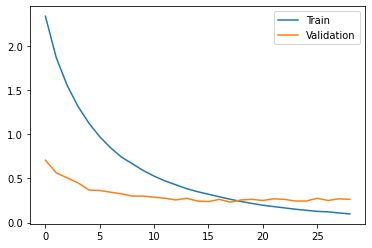

In [ ]:
print_train_val_graph(net)

##### Validación

In [ ]:
Y_predict_4 = pipe4.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_4)

Accuracy: 0.645
Precision: 0.6512455222053687
Recall: 0.645
F1-Score: 0.6456119793861993


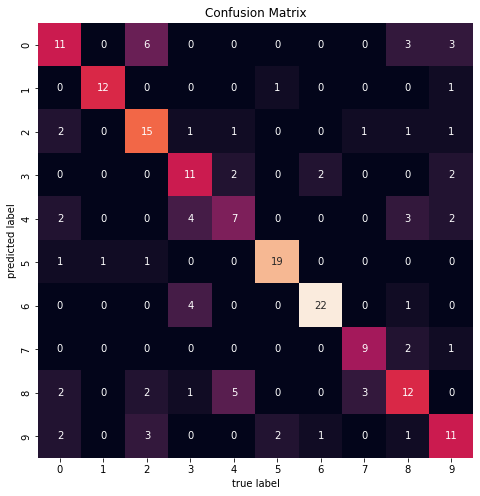

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_4)

#### Experimento 5

In [ ]:
# params_exp_5={
#         "network__hidden_layer_sizes": (64,64),
#         "network__activation":"tanh",
#         "network__alpha": 0.001,
#         "network__batch_size":64,
#         "network__solver": "adam",
#         "network__validation_fraction":0.2,
#         #"network__n_iter_no_change":15,
#         #"network__early_stopping":True,
#         "network__learning_rate": "adaptive",
#         "network__learning_rate_init": 0.003,
#         "network__max_iter":10000000
# }


params_exp_5={
        "network__hidden_layer_sizes": (128,64,32),
        "network__batch_size":32,
        "network__activation":"relu",
        "network__solver": "adam",
        "network__early_stopping":True,
        "network__n_iter_no_change":10,
        "network__validation_fraction":0.2,
        "network__learning_rate": "adaptive",
        "network__learning_rate_init": 0.00025,
        "network__max_iter":1000000000
}

In [ ]:
pipe5.set_params(**params_exp_5)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(128, 64, 32),
                               learning_rate='adaptive',
                               learning_rate_init=0.00025, max_iter=1000000000,
                               validation_fraction=0.2))])

##### Entrenamiento

In [ ]:
pipe5.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('network',
                 MLPClassifier(batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(128, 64, 32),
                               learning_rate='adaptive',
                               learning_rate_init=0.00025, max_iter=1000000000,
                               validation_fraction=0.2))])

In [ ]:
net = pipe5.named_steps['network']

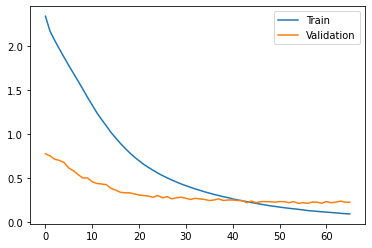

In [ ]:
print_train_val_graph(net)

##### Validación

In [ ]:
Y_predict_5 = pipe5.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_5)

Accuracy: 0.72
Precision: 0.7265674395049395
Recall: 0.72
F1-Score: 0.713846003112615


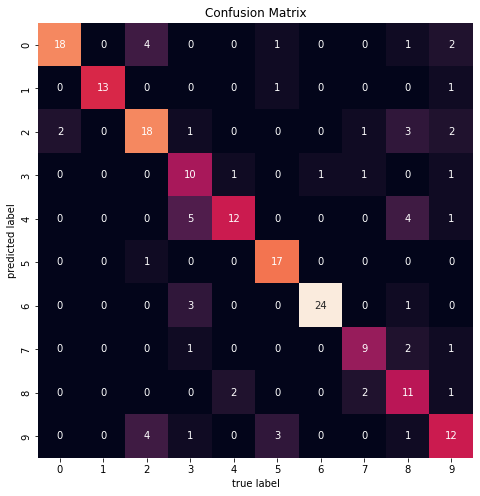

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_5)

### Random Forest

In [ ]:
pipe6 = pipeline.Pipeline([('standarizer', standarizer), ('forest', radomForestModel)])
pipe7 = pipeline.Pipeline([('standarizer', standarizer), ('forest', radomForestModel)])
pipe8 = pipeline.Pipeline([('standarizer', standarizer), ('forest', radomForestModel)])
pipe9 = pipeline.Pipeline([('standarizer', standarizer), ('forest', radomForestModel)])

#### Experimento 1

In [ ]:
params_exp_1={
        "forest__criterion": "gini",
        "forest__n_estimators": 1000,
        "forest__max_depth": 10,
}

In [ ]:
pipe6.set_params(**params_exp_1)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(max_depth=10, n_estimators=1000))])

##### Entrenamiento

In [ ]:
pipe6.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(max_depth=10, n_estimators=1000))])

##### Validación

In [ ]:
Y_predict_1 = pipe6.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_1)

Accuracy: 0.73
Precision: 0.7351796059990054
Recall: 0.73
F1-Score: 0.7259344316094447


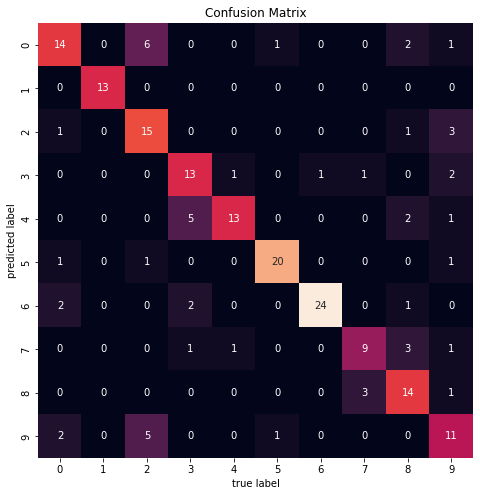

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_1)

#### Experimento 2

In [ ]:
params_exp_2={
        "forest__criterion": "gini",
        "forest__n_estimators": 2000,
        "forest__max_depth": 20,
}

In [ ]:
pipe7.set_params(**params_exp_2)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(max_depth=20, n_estimators=2000))])

##### Entrenamiento

In [ ]:
pipe7.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(max_depth=20, n_estimators=2000))])

##### Validación

In [ ]:
Y_predict_2 = pipe7.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_2)

Accuracy: 0.755
Precision: 0.7612935418255785
Recall: 0.755
F1-Score: 0.753091420388712


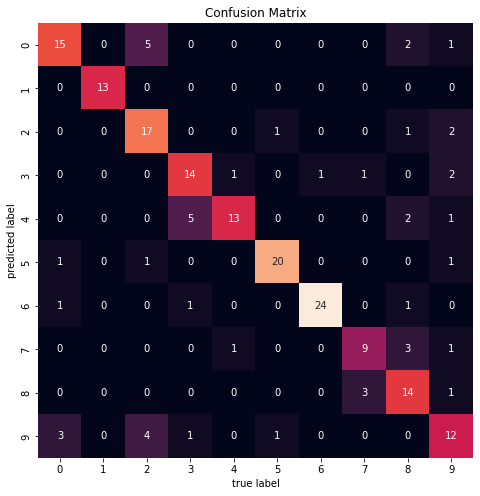

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_2)

#### Experimento 3

In [ ]:
params_exp_3={
        "forest__criterion": "entropy",
        "forest__n_estimators": 1000,
        "forest__max_depth": 10,
}

In [ ]:
pipe8.set_params(**params_exp_3)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=1000))])

##### Entrenamiento

In [ ]:
pipe8.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=1000))])

##### Validación

In [ ]:
Y_predict_3 = pipe8.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_3)

Accuracy: 0.75
Precision: 0.7507648864809081
Recall: 0.75
F1-Score: 0.744804523076282


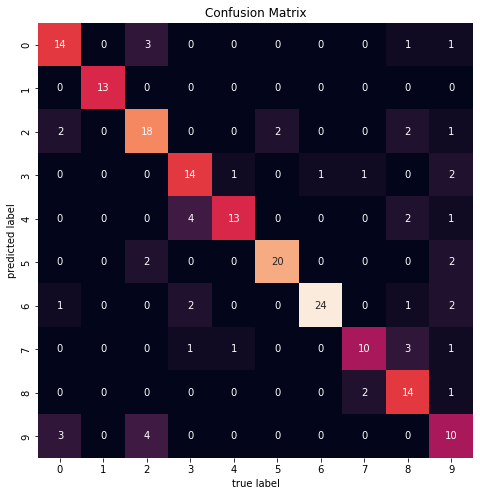

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_3)

#### Experimento 4

In [ ]:
params_exp_4={
        "forest__criterion": "entropy",
        "forest__n_estimators": 2000,
        "forest__max_depth": 20,
}

In [ ]:
pipe9.set_params(**params_exp_4)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=20,
                                        n_estimators=2000))])

##### Entrenamiento

In [ ]:
pipe9.fit(X_train,Y_train)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=20,
                                        n_estimators=2000))])

In [ ]:
import joblib

joblib.dump(pipe9, "model.pkl")

['model.pkl']

##### Validación

In [ ]:
Y_predict_4 = pipe9.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_4)

Accuracy: 0.775
Precision: 0.7776153381642513
Recall: 0.775
F1-Score: 0.7730907368575949


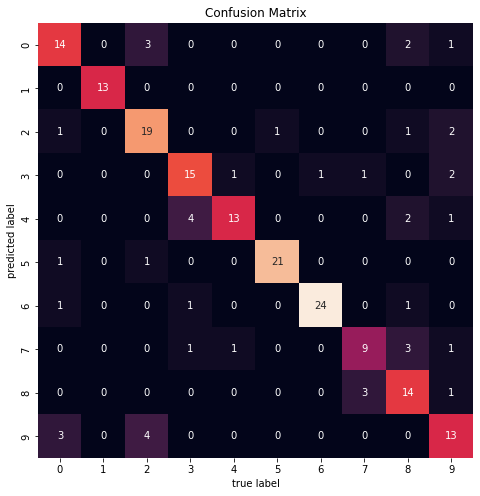

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_4)

### Regresión logística

In [ ]:
pipe11 = pipeline.Pipeline([('standarizer', standarizer), ('logistic', logistcModel)])
pipe12 = pipeline.Pipeline([('standarizer', standarizer), ('logistic', logistcModel)])

#### Experimento 1

In [ ]:
params_exp_1={
        "logistic__penalty": "none",
        "logistic__random_state":0
}

In [ ]:
pipe11.set_params(**params_exp_1)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('logistic',
                 LogisticRegression(penalty='none', random_state=0))])

##### Entrenamiento

In [ ]:
pipe11.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('standarizer', StandardScaler()),
                ('logistic',
                 LogisticRegression(penalty='none', random_state=0))])

##### Validación

In [ ]:
Y_predict_1 = pipe11.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_1)

Accuracy: 0.58
Precision: 0.5938424900991531
Recall: 0.58
F1-Score: 0.5825269407174711


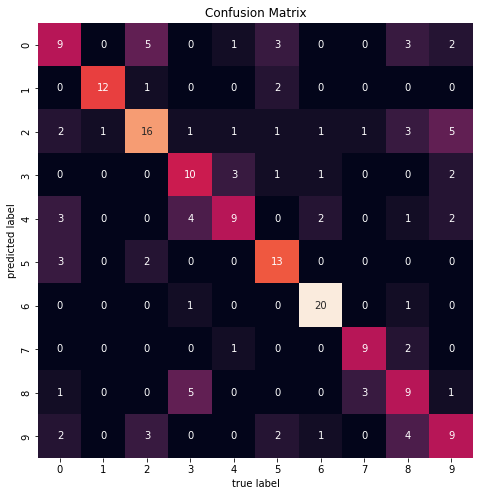

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_1)

#### Experimento 2

In [ ]:
params_exp_2={
        "logistic__penalty": "l2",
        "logistic__random_state":0
}

In [ ]:
pipe12.set_params(**params_exp_2)

Pipeline(steps=[('standarizer', StandardScaler()),
                ('logistic', LogisticRegression(random_state=0))])

##### Entrenamiento

In [ ]:
pipe12.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('standarizer', StandardScaler()),
                ('logistic', LogisticRegression(random_state=0))])

##### Validación

In [ ]:
Y_predict_2 = pipe12.predict(X_test)

In [ ]:
print_stats(Y_test,Y_predict_2)

Accuracy: 0.63
Precision: 0.6401096037194435
Recall: 0.63
F1-Score: 0.632662183949535


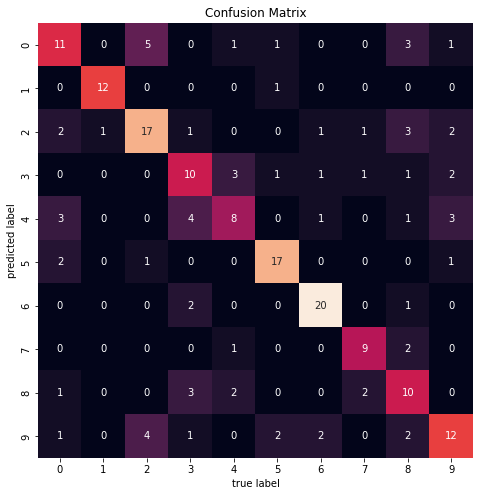

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,Y_predict_2)